In [1]:
(*'This cell imports the list of file names'*)
(*'fileNames.csv should contain two columns. The first column gives'*)
(*'the JPEG image file name (without extension), and the second '*)
(*'column gives the polarizer angle (in degrees).'*)
fileNames = Import["fileNames.csv"];
exampleImgFileName = StringJoin[ToString[fileNames[[1]][[2]]], ".JPG"];
exampleImg = Import[exampleImgFileName];
fileNameList = Table[StringJoin[ToString[fileNames[[i]][[2]]], ".JPG"], {i, 1, Length[fileNames]}];

(*'Prints out the image file names'*)
fileNameList

{0.JPG, 10.JPG, 20.JPG, 30.JPG, 40.JPG, 50.JPG, 60.JPG, 70.JPG, 80.JPG, 90.JPG, 100.JPG, 110.JPG, 120.JPG, 130.JPG, 140.JPG, 150.JPG, 160.JPG, 170.JPG, 180.JPG}

In [7]:
(*'The cell retrieves relevant information for the image'*)
(*'And generate the list of roi for segmentation later'*)
exampleImgSize = ImageDimensions[exampleImg]
imgSizeX = exampleImgSize[[1]];
imgSizeY = exampleImgSize[[2]];
centerX = imgSizeX/2;
centerY = imgSizeY/2;
halfWinSize = 10;
nPts = 9; (*'not really the number of points'*)
winCenterList = Table[Table[{centerX + 2*i*halfWinSize, centerY + 2*j*halfWinSize},{j, -nPts, nPts}], {i, -nPts, nPts}];
winCenterList = Flatten[winCenterList, 1];
getRec[cent_, halfS_]:= {{cent[[1]] - halfS, cent[[2]] - halfS},
                        {cent[[1]] - halfS, cent[[2]] + halfS},
                        {cent[[1]] + halfS, cent[[2]] + halfS},
                        {cent[[1]] + halfS, cent[[2]] - halfS},
                        {cent[[1]] - halfS, cent[[2]] - halfS}};
roiList = Table[getRec[winCenterList[[i]], halfWinSize], {i, 1, Length[winCenterList]}];

{1280, 720}

centerPtPlt done
roiPlt done



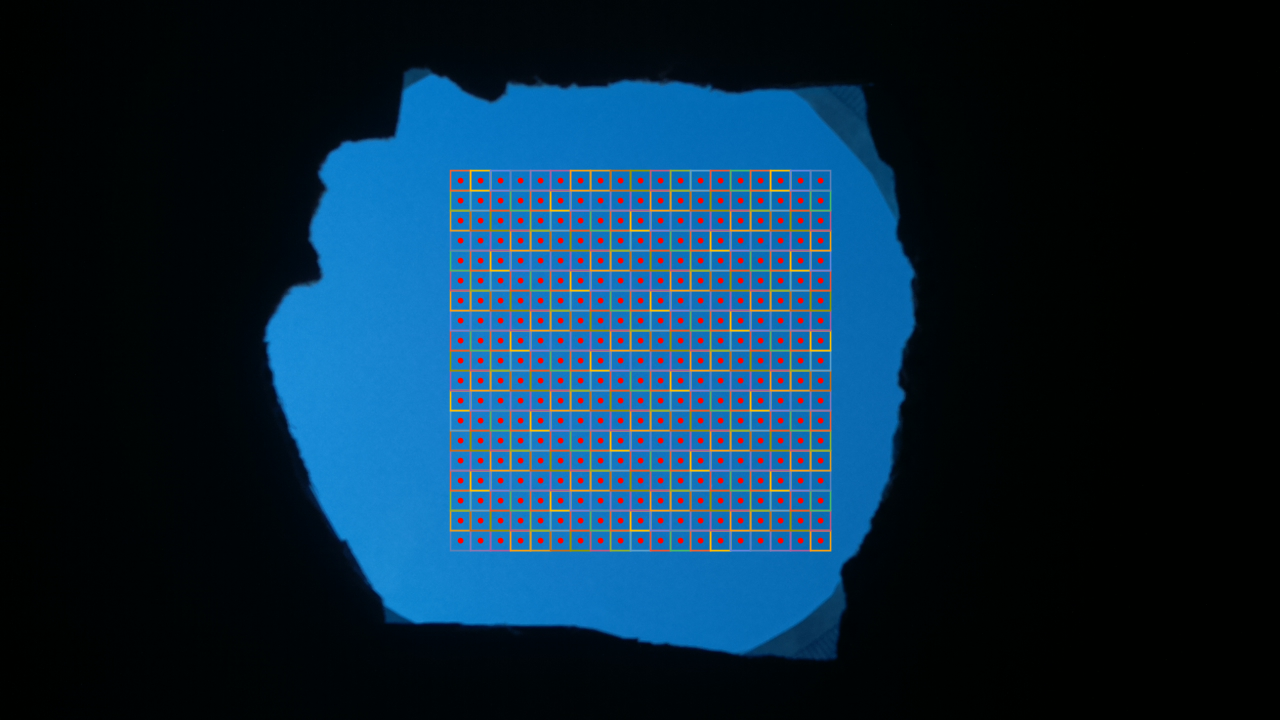

In [20]:
(*'This cell just illustrates how the selected rois are like'*)
centerPtPlt = ListPlot[winCenterList, PlotStyle->{Red}, PlotMarkers->{Automatic, Small}];
Print["centerPtPlt done"];
roiPlt = ListPlot[roiList, Joined->True];
Print["roiPlt done"];
Show[exampleImg, centerPtPlt, roiPlt]

In [26]:
(*'This cell defines the image processing function'*)
processImg[currImg_, RoiList_]:=
    (
        resultList = {};
        maxStd = 0;
        For[i = 1, i <= Length[RoiList], i = i + 1,
            trimmedImg = ImageTrim[currImg, RoiList[[i]]];
            blueChannel = ColorSeparate[trimmedImg][[3]];
            mean = ImageMeasurements[blueChannel, "MeanIntensity"];
            std = ImageMeasurements[blueChannel, "StandardDeviationIntensity"];
            If[std > maxStd, maxStd = std];
            AppendTo[resultList, mean];
           ];
        Print[Round[maxStd*255]];
        resultList
    )

2
2
2
2
2
7
6
8
5
3
2
2
4
4
3
3
2
2
2



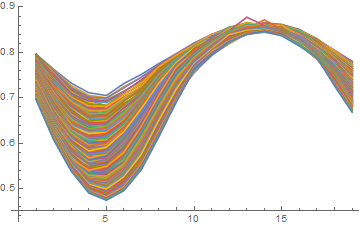

In [28]:
(*'This cell runs the image processing function,'*)
(*'and the max std of each all segments in an image is printed [0, 255]'*)
intensityVal = {};
For[imgInd = 1, imgInd <= Length[fileNameList], imgInd = imgInd + 1,
    currImg = Import[fileNameList[[imgInd]]];
    outcome = processImg[currImg, roiList];
    AppendTo[intensityVal, outcome];
   ];
ListPlot[Transpose[intensityVal], Joined->True]


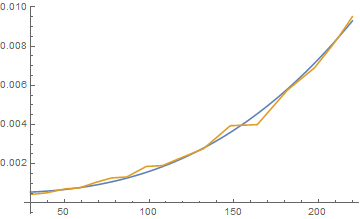

In [33]:
(*'Camera calibration data should be copied to here'*)
(*'calibData is a n*2 list. Each pair in the list gives'*)
(*'{relative radiant energy, sensor value}'*)
calibData = {{0.009994, 223.756}, {0.008272, 210.266}, {0.006907, 197.678}, {0.005769, 181.66}, 
             {0.004005, 163.852}, {0.003949, 147.92}, {0.002774, 132.069}, {0.00231, 118.775}, 
             {0.001915, 107.872}, {0.001869, 98.2515}, {0.001335, 86.777}, {0.001284, 77.8716}, 
             {0.001056, 68.345}, {0.000778, 58.9407}, {0.000731, 50.6605}, {0.000522, 39.4802}, 
             {0.000471, 33.5273}, {0.000406, 25.2464}, {0.000309, 18.7696}};
calibData = Transpose[calibData];
calibData = Transpose[{calibData[[2]], calibData[[1]]}];
calibFuncInt = Interpolation[calibData, InterpolationOrder->1];
calibFuncFit = NonlinearModelFit[calibData, c*x^b + d, {c, b, d}, x];
Plot[{calibFuncFit[x], calibFuncInt[x]}, {x, 30, 220}] (*'the fitted one is obviously smoother, and that helps'*)

In [39]:
(*'This cell runs the fitting of a sine curve for each of the image segments'*)
(*'The fitted curve can be exported to a subfolder (output) which must be created in advance'*)
polarAngleDeg = N[Transpose[fileNames][[1]]];
polarAngle = polarAngleDeg / 180 * Pi;
intensityValT = Transpose[intensityVal];
plts = {};
exportEnabled = False;
bFitList = {};
cFitList = {};
dFitList = {};
rSquareList = {};
For[ptInd = 1, ptInd <=Length[winCenterList], ptInd = ptInd + 1,
    currPt = winCenterList[[ptInd]];
    currIntensity = intensityValT[[ptInd]]*255;
    currIntensityAdjusted = Map[calibFuncFit, currIntensity];
    currVar = Transpose[{polarAngle, currIntensityAdjusted}];

    nlm = NonlinearModelFit[currVar, b * Cos[2*x + d] + c, {b, c, d}, x];
    p1 = Plot[nlm[x], {x, 0, Pi}];
    p2 = ListPlot[currVar];
    
    param = nlm["ParameterTable"];
    rSquare = nlm["AdjustedRSquared"];
    AppendTo[rSquareList, rSquare];
    bFit = param[[1]][[1]][[2]][[2;;3]]; (*Fitted Val, error*)
    AppendTo[bFitList, bFit[[1]]];
    cFit = param[[1]][[1]][[3]][[2;;3]];
    AppendTo[cFitList, cFit[[1]]];
    dFit = param[[1]][[1]][[4]][[2;;3]];
    AppendTo[dFitList, dFit[[1]]];
    If[exportEnabled,
        outputImg = ImageCollage[{Rasterize[param], Rasterize[Show[p1, p2]]}];
        Export[StringJoin[{"output\\", ToString[ptInd], "Processed.png"}], outputImg];];
    (*'Just print something to see where we at'*)
    If[Mod[ptInd, 20]== 0, Print[ptInd]];
   ]

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360



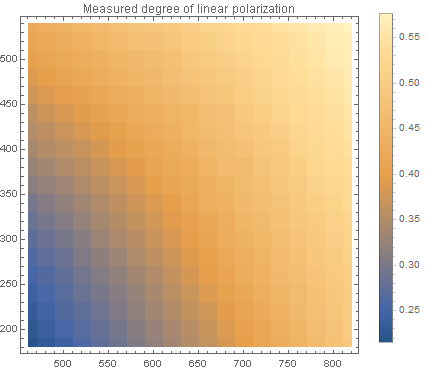

In [117]:
(*'Calculate the degree of linear polarization'*)
fracPolarized = bFitList/(cFitList);

(*'Plot the degree of linear polarization'*)
(*'Note that the axis is in pixels'*)
pltPtList = Transpose[winCenterList];
pltValList = Transpose[{pltPtList[[1]], pltPtList[[2]], fracPolarized}];
measuredPlt = ListDensityPlot[pltValList, PlotLegends -> Automatic, InterpolationOrder->0,
                             PlotLabel ->"Measured degree of linear polarization"]

In [120]:
(*'Convert image coordinates to direction of imaging'*)
(*'It is assumed that the camera is using its full horizontal field of view.'*)
horizWidth = exampleImgSize[[1]];
horizFOV = 53.5/180*Pi;
h = horizWidth/2/Tan[horizFOV/2];



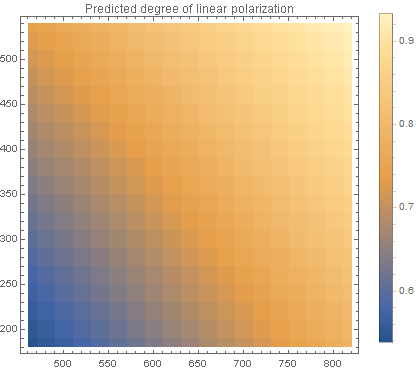

In [151]:
(*'Compute the solar dir'*)
(*'These two values are quoted from stellarium directly'*)
az = 218.0/180*Pi;
alt = 22.0/180*Pi;
(*'These two are the polar angles in the camera frame'*)
(*'This probably needs adjustment depending on camera orientation'*)
phiS = az;
thetaS = Pi/2 - alt;
solarDirVec = {Sin[thetaS]*Cos[phiS], Sin[thetaS]*Sin[phiS], Cos[thetaS]};

(*'Compute the img observation point dir'*)
computeFracPolarized[currImgPt_, solarDirVec_]:=
(
    imgCoordCent = {currImgPt[[1]] - exampleImgSize[[1]]/2, currImgPt[[2]] - exampleImgSize[[2]]/2};
    obsDirVec = {imgCoordCent[[1]], imgCoordCent[[2]], h};
    obsDirVec = obsDirVec/Norm[obsDirVec];

    angleDiff = ArcCos[Dot[obsDirVec, solarDirVec]];
    dLinearPredicted = Sin[angleDiff]^2/(1 + Cos[angleDiff]^2)
)
    
fracPolarizedPredicted = Table[computeFracPolarized[winCenterList[[i]],solarDirVec], {i, 1, Length[winCenterList]}];
pltValListPred = Transpose[{pltPtList[[1]], pltPtList[[2]], fracPolarizedPredicted}];
predictedPlt = ListDensityPlot[pltValListPred, PlotLegends -> Automatic, InterpolationOrder->0, 
                               PlotLabel ->"Predicted degree of linear polarization"]

General::munfl: 
 Exp[-811.367] is too small to represent as a normalized machine number;
 precision may be lost.
 
 
 Out[169]:
 
 
 
 
 Out[170]:
 
 
 
 
 Out[171]:
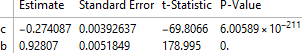
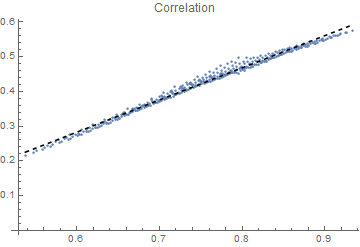

In [167]:
corrData = Transpose[{fracPolarizedPredicted, fracPolarized}];
linearCorr = NonlinearModelFit[corrData, b*x + c, {c, b}, x];
param = linearCorr["ParameterTable"]
rSquare = linearCorr["AdjustedRSquared"]
corrPlt =Show[ListPlot[corrData], 
              Plot[linearCorr[x], {x, Min[fracPolarizedPredicted], Max[fracPolarizedPredicted]}, PlotStyle->{Dashed, Black}], 
              PlotLabel ->"Correlation"]

Out[173]:
 
 
 
 
 Out[174]:
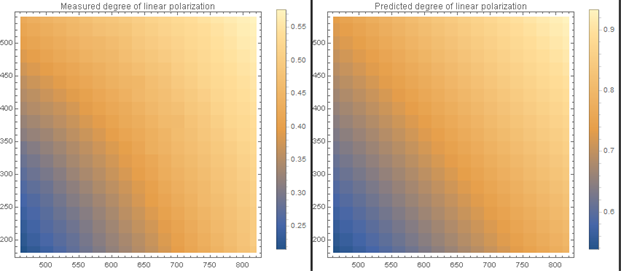
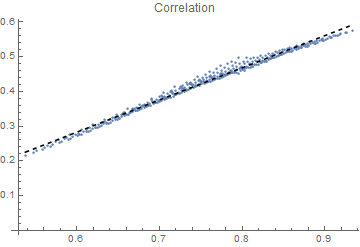

In [172]:
(*'The cell that summarizes the results'*)
ImageCollage[{Rasterize[measuredPlt], Rasterize[predictedPlt]}]
corrPlt

Out[177]:
 
 
 
 
 Out[178]:
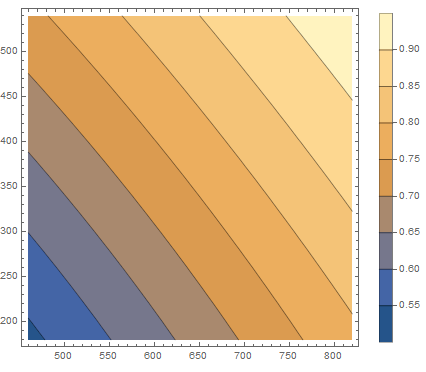
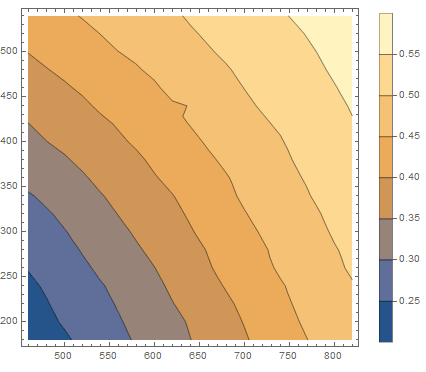

In [177]:
(*'The density plot can be given as well.'*)
ListContourPlot[pltValListPred, InterpolationOrder -> 1, PlotLegends -> Automatic]
ListContourPlot[pltValList, InterpolationOrder -> 1, PlotLegends -> Automatic]